## Semantic role labelling with BERT

### Install libraries if needed

In [1]:
# !pip install -r requirements.txt

In [2]:
import warnings
warnings.filterwarnings('ignore')

from code_.process_conll import process_file, advanced_process_file
from code_.bert import Tokenizer, convert_to_dataset, compute_metrics, get_labels_list_from_dataset, predict, batch_size, model_checkpoint
from transformers import AutoModelForTokenClassification, TrainingArguments, Trainer
from transformers import DataCollatorForTokenClassification
from datasets import load_metric

Loading datasets

In [3]:
df_val = process_file('data/raw/en_ewt-up-dev.conllu')
df_train = process_file('data/raw/en_ewt-up-train.conllu')
df_test = process_file('data/raw/en_ewt-up-test.conllu')

process_file(): dataframe len: 4979
process_file(): dataframe len: 40498
process_file(): dataframe len: 4802


Prepare dataset and labels

In [4]:
dataset = convert_to_dataset(df_train, df_val, df_test)
labels_list = get_labels_list_from_dataset(dataset)
# print(labels_list)

tok = Tokenizer(model_checkpoint, labels_list)
tokenized_datasets = dataset.map(tok.tokenize_and_align_labels_pred, batched=True)

Map:   0%|          | 0/40498 [00:00<?, ? examples/s]

Map:   0%|          | 0/4979 [00:00<?, ? examples/s]

Map:   0%|          | 0/4802 [00:00<?, ? examples/s]

Prepare model and hyperparameters

In [5]:
model = AutoModelForTokenClassification.from_pretrained('model_checkpoints/baseline', num_labels=len(labels_list))

args = TrainingArguments(
    f"model_checkpoints/baseline",
    evaluation_strategy = 'epoch',
    save_steps=1000,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    push_to_hub=False,
)

data_collator = DataCollatorForTokenClassification(tok.tokenizer)
metric = load_metric("seqeval")

trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tok.tokenizer,
    compute_metrics=compute_metrics
)

Train it and save results

In [6]:
# trainer.train()
# trainer.save_model()

And use the model to predict results

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/78 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      'ARG0'       0.81      0.85      0.83      1389
      'ARG1'       0.79      0.86      0.82      3218
  'ARG1-DSP'       0.00      0.00      0.00         0
      'ARG2'       0.71      0.73      0.72      1298
      'ARG3'       0.00      0.00      0.00        82
      'ARG4'       0.51      0.33      0.40        54
      'ARG5'       0.00      0.00      0.00         1
      'ARGA'       0.00      0.00      0.00         0
  'ARGM-ADJ'       0.69      0.69      0.69       235
  'ARGM-ADV'       0.65      0.57      0.61       454
  'ARGM-CAU'       0.55      0.48      0.51        62
  'ARGM-COM'       0.00      0.00      0.00        15
  'ARGM-CXN'       1.00      0.14      0.25        14
  'ARGM-DIR'       0.47      0.40      0.43        52
  'ARGM-DIS'       0.76      0.53      0.62        97
  'ARGM-EXT'       0.74      0.71      0.73       114
  'ARGM-GOL'       0.00      0.00      0.00        28
  'ARGM-LOC'       0.50    

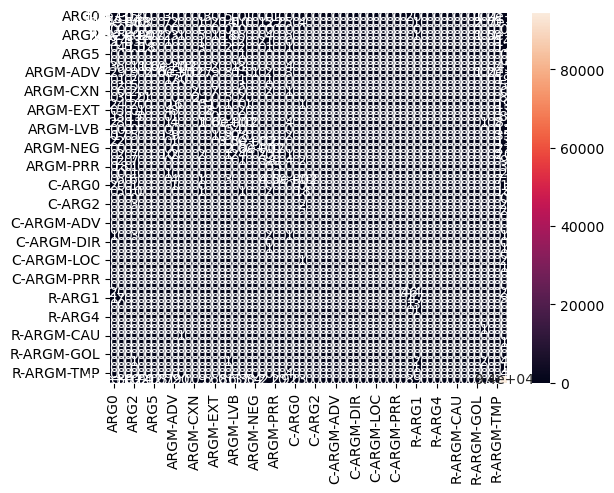

In [7]:
predict(trainer, tok, dataset, tokenized_datasets, test_set='validation')
# predict(trainer, tok, dataset, tokenized_datasets, test_set='test')

### Doing same preparation in a single cell for advanced model (the one with context of predicate)

In [10]:
df_val = advanced_process_file('data/raw/en_ewt-up-dev.conllu')
df_train = advanced_process_file('data/raw/en_ewt-up-train.conllu')
df_test = advanced_process_file('data/raw/en_ewt-up-test.conllu')

dataset = convert_to_dataset(df_train, df_val, df_test)
labels_list = get_labels_list_from_dataset(dataset)

tok = Tokenizer(model_checkpoint, labels_list)
tokenized_datasets = dataset.map(tok.tokenize_and_align_labels_context, batched=True)
model = AutoModelForTokenClassification.from_pretrained('model_checkpoints/context', num_labels=len(labels_list))

args = TrainingArguments(
    f"model_checkpoints/context",
    evaluation_strategy = 'epoch',
    learning_rate=2e-5,
    save_steps=1000,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=5,
    weight_decay=0.01,
    push_to_hub=False,
)
data_collator = DataCollatorForTokenClassification(tok.tokenizer)
metric = load_metric("seqeval")
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tok.tokenizer,
    compute_metrics=compute_metrics
)
# trainer.train()
# trainer.save_model()

Map:   0%|          | 0/40498 [00:00<?, ? examples/s]

Map:   0%|          | 0/4979 [00:00<?, ? examples/s]

Map:   0%|          | 0/4802 [00:00<?, ? examples/s]

And predict

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


  0%|          | 0/78 [00:00<?, ?it/s]

              precision    recall  f1-score   support

      'ARG0'       0.81      0.86      0.83      1389
      'ARG1'       0.82      0.86      0.84      3218
  'ARG1-DSP'       0.00      0.00      0.00         0
      'ARG2'       0.73      0.75      0.74      1298
      'ARG3'       0.00      0.00      0.00        82
      'ARG4'       0.63      0.48      0.55        54
      'ARG5'       0.00      0.00      0.00         1
      'ARGA'       0.00      0.00      0.00         0
  'ARGM-ADJ'       0.70      0.73      0.71       235
  'ARGM-ADV'       0.68      0.60      0.64       454
  'ARGM-CAU'       0.43      0.47      0.45        62
  'ARGM-COM'       0.00      0.00      0.00        15
  'ARGM-CXN'       1.00      0.14      0.25        14
  'ARGM-DIR'       0.41      0.40      0.41        52
  'ARGM-DIS'       0.77      0.58      0.66        97
  'ARGM-EXT'       0.80      0.75      0.78       114
  'ARGM-GOL'       0.00      0.00      0.00        28
  'ARGM-LOC'       0.52    

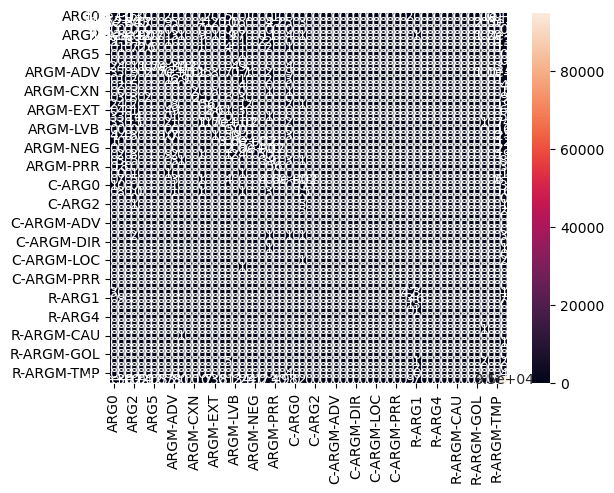

In [11]:
predict(trainer, tok, dataset, tokenized_datasets, test_set='validation')
# predict(trainer, tok, dataset, tokenized_datasets, test_set='test')